In [1]:
import numpy as np
import scipy.stats as stats
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like  = stats.bernoulli(θ).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

In [3]:
Y = stats.bernoulli(0.7).rvs(20)

In [4]:
n_iters = 1000
can_sd = 0.05
α = β =  1
θ = 0.5
trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, Y, α, β)
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace["θ"][iter] = θ

/var/folders/l2/z_qwg8756fgc432r7nwvww480000gn/T/ipykernel_6152/590635475.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  trace["θ"][iter] = θ


[]

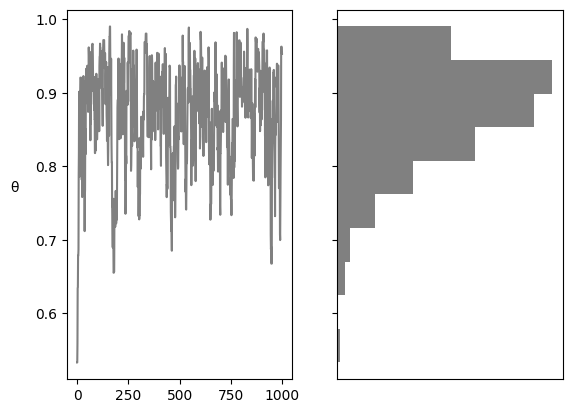

In [5]:
_, axes = plt.subplots(1,2, sharey=True)
axes[0].plot(trace['θ'], '0.5')
axes[0].set_ylabel('θ', rotation=0, labelpad=15)
axes[1].hist(trace['θ'], color='0.5', orientation="horizontal", density=True)
axes[1].set_xticks([])

In [6]:
az.summary(trace, kind="stats", round_to=2)

,mean,sd,hdi_3%,hdi_97%
θ,0.87,0.07,0.74,0.98


<Axes: title={'center': 'θ'}>

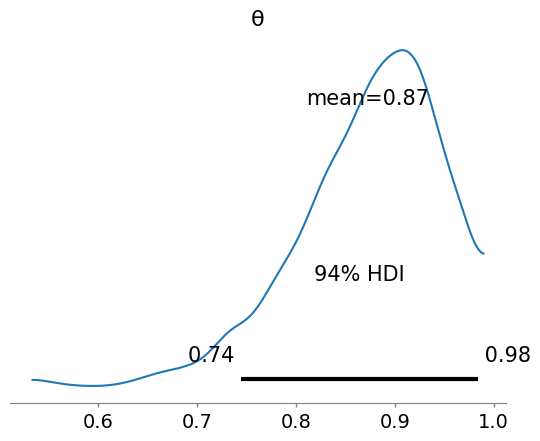

In [7]:
az.plot_posterior(trace)


In [8]:
# b# Declare a model in PyMC3
# with pm.Model() as model:
#     # Specify the prior distribution of unknown parameter
#     θ = pm.Beta("θ", alpha=1, beta=1)

#     # Specify the likelihood distribution and condition on the observed data
#     y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)

#     # Sample from the posterior distribution
#     idata = pm.sample(1000, return_inferencedata=True)

In [9]:
# Define the model
model = pm.Model()

# Add components to the model within the context manager
with model:
    # Specify the prior distribution of unknown parameter
    θ = pm.Beta("θ", alpha=1, beta=1)

    # Specify the likelihood distribution and condition on the observed data
    y_obs = pm.Binomial("y_obs", n=1, p=θ, observed=Y)

# Sample from the posterior distribution outside the context manager
idata = pm.sample(1000, return_inferencedata=True, model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


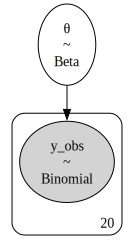

In [10]:
pm.model_to_graphviz(model)

In [12]:
pred_dists = (pm.sample_prior_predictive(1000, model)["y_obs"],
              pm.sample_posterior_predictive(idata, 1000, model)["y_obs"])

Sampling: [y_obs, θ]


KeyError: 'y_obs'

In [15]:
pm.sample_prior_predictive(1000, model)

Sampling: [y_obs, θ]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [16]:
pm.sample_posterior_predictive(idata, 1000, model)

AttributeError: 'int' object has no attribute 'potentials'

In [17]:
model

    θ ~ Beta(1, 1)
y_obs ~ Binomial(1, θ)